In [1]:
import autoreg
import GPy
import numpy as np
from pylab import *
import tables
from IPython.display import HTML
%matplotlib inline

In [2]:
def gen_frames(data, data_mean, data_std, skel, imgpath):
    import os
    import GPy
    a = np.zeros((62,))
    fig = figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d',aspect='equal')
    ax.view_init(elev=20., azim=65)
    fig.tight_layout()
    a[3:] = (data[0])*data_out_std+data_out_mean
    p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
    for i in xrange(data.shape[0]):
        a[3:] = (data[i])*data_out_std+data_out_mean
        p.modify(a)
        fig.savefig(os.path.join(imgpath,'%05d'%i+'.png'))

In [3]:
from GPy.util.datasets import *

def cmu_mocap_xyz(subject, train_motions, test_motions=[], sample_every=4, data_set='cmu_mocap'):
    """Load a given subject's training and test motions from the CMU motion capture data."""
    # Load in subject skeleton.
    subject_dir = os.path.join(data_path, data_set)

    # Make sure the data is downloaded.
    all_motions = train_motions + test_motions
    resource = cmu_urls_files(([subject], [all_motions]))
    data_resources[data_set] = data_resources['cmu_mocap_full'].copy()
    data_resources[data_set]['files'] = resource['files']
    data_resources[data_set]['urls'] = resource['urls']
    if resource['urls']:
        download_data(data_set)

    skel = GPy.util.mocap.acclaim_skeleton(os.path.join(subject_dir, subject + '.asf'))
    
    
    for i in range(len(skel.vertices)):
        print i, skel.vertices[i].name     

    
    # 0 root
    # 1 lhipjoint
    # 2 lfemur
    # 3 ltibia
    # 4 lfoot
    # 5 ltoes
    # 6 rhipjoint
    # 7 rfemur
    # 8 rtibia
    # 9 rfoot
    # 10 rtoes
    # 11 lowerback
    # 12 upperback
    # 13 thorax
    # 14 lowerneck
    # 15 upperneck
    # 16 head
    # 17 lclavicle
    # 18 lhumerus
    # 19 lradius
    # 20 lwrist
    # 21 lhand
    # 22 lfingers
    # 23 lthumb
    # 24 rclavicle
    # 25 rhumerus
    # 26 rradius
    # 27 rwrist
    # 28 rhand
    # 29 rfingers
    # 30 rthumb

    
    
    
    
    # Set up labels for each sequence
    exlbls = np.eye(len(train_motions))

    # Load sequences
    tot_length = 0
    temp_Y = []
    temp_Yxyz = []
    temp_lbls = []
    #u_inds = [15,16,17]
    #root_inds = [0,1,2]
    u_inds=[17]
    root_inds = [2]
    
    for i in range(len(train_motions)):
        temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + train_motions[i] + '.amc'))
        #temp_xyz_chan = skel.to_xyz(temp_chan.flatten()) ## A
        # Apparently the above is equiv. to giving temp_chan[0,:]. It's returning a 31 x 3 matrix.
        # I need to do this for every temp_chan[j,:], and serialize the result. The toe should be the
        # very last dimension (I think).
        #temp_xyz_chan = np.zeros((temp_chan.shape[0],93))
        #A -------
        temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
        for j in range(temp_xyz_chan.shape[0]):                                 
            foo = skel.to_xyz(temp_chan[j,:]).flatten()
            temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
        #----A
        temp_Y.append(temp_chan[::sample_every, :])
        temp_Yxyz.append(temp_xyz_chan[::sample_every, :]) ## A
        temp_lbls.append(np.tile(exlbls[i, :], (temp_Y[i].shape[0], 1)))
        tot_length += temp_Y[i].shape[0]

    Y = np.zeros((tot_length, temp_Y[0].shape[1]))
    Yxyz = np.zeros((tot_length, temp_Yxyz[0].shape[1])) #A
    lbls = np.zeros((tot_length, temp_lbls[0].shape[1]))

    #pb.plot(temp_Yxyz[-1][:,15:18]-temp_Yxyz[-1][:,0:3],'x-')

    end_ind = 0
    for i in range(len(temp_Y)):
        start_ind = end_ind
        end_ind += temp_Y[i].shape[0]
        Y[start_ind:end_ind, :] = temp_Y[i]
        Yxyz[start_ind:end_ind, :] = temp_Yxyz[i] #A
        lbls[start_ind:end_ind, :] = temp_lbls[i]
    if len(test_motions) > 0:
        temp_Ytest = []
        temp_lblstest = []
        temp_Yxyz_test = []

        testexlbls = np.eye(len(test_motions))
        tot_test_length = 0
        for i in range(len(test_motions)):
            temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + test_motions[i] + '.amc'))
            #A -------
            temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
            for j in range(temp_xyz_chan.shape[0]):                                 
                foo = skel.to_xyz(temp_chan[j,:]).flatten()
                temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
            #----A
            temp_Ytest.append(temp_chan[::sample_every, :])
            temp_Yxyz_test.append(temp_xyz_chan[::sample_every, :]) ## A
            temp_lblstest.append(np.tile(testexlbls[i, :], (temp_Ytest[i].shape[0], 1)))
            tot_test_length += temp_Ytest[i].shape[0]

        # Load test data
        Ytest = np.zeros((tot_test_length, temp_Ytest[0].shape[1]))
        Yxyz_test = np.zeros((tot_test_length, temp_Yxyz_test[0].shape[1])) #A
        lblstest = np.zeros((tot_test_length, temp_lblstest[0].shape[1]))

        end_ind = 0
        for i in range(len(temp_Ytest)):
            start_ind = end_ind
            end_ind += temp_Ytest[i].shape[0]
            Ytest[start_ind:end_ind, :] = temp_Ytest[i]
            Yxyz_test[start_ind:end_ind, :] = temp_Yxyz_test[i] #A
            lblstest[start_ind:end_ind, :] = temp_lblstest[i]
    else:
        Ytest = None
        lblstest = None

    info = 'Subject: ' + subject + '. Training motions: '
    for motion in train_motions:
        info += motion + ', '
    info = info[:-2]
    if len(test_motions) > 0:
        info += '. Test motions: '
        for motion in test_motions:
            info += motion + ', '
        info = info[:-2] + '.'
    else:
        info += '.'
    if sample_every != 1:
        info += ' Data is sub-sampled to every ' + str(sample_every) + ' frames.'
    return data_details_return({'Y': Y, 'lbls' : lbls, 'Ytest': Ytest, 'lblstest' : lblstest, 'info': info, 'skel': skel,'Yxyz':Yxyz,'Yxyz_test':Yxyz_test,'u_inds':u_inds,'root_inds':root_inds,'Yxyz_list':temp_Yxyz,'Yxyz_list_test':temp_Yxyz_test}, data_set)




In [4]:
def load_data():
    from GPy.util.datasets import cmu_mocap
    train_motions = ['01', '02', '03', '04', # walking
                '17', '18', '19', '20'] # running
    test_motions = ['05','21']
    data = cmu_mocap('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

def load_data_xyz():
    train_motions = ['01', '02', '03', '04', # walking
                '17', '18', '19', '20'] # running
    test_motions = ['05','21']
    data = cmu_mocap_xyz('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

In [5]:
#data = load_data()
data = load_data_xyz()

0 root
1 lhipjoint
2 lfemur
3 ltibia
4 lfoot
5 ltoes
6 rhipjoint
7 rfemur
8 rtibia
9 rfoot
10 rtoes
11 lowerback
12 upperback
13 thorax
14 lowerneck
15 upperneck
16 head
17 lclavicle
18 lhumerus
19 lradius
20 lwrist
21 lhand
22 lfingers
23 lthumb
24 rclavicle
25 rhumerus
26 rradius
27 rwrist
28 rhand
29 rfingers
30 rthumb


In [6]:

y = data['Y']
u = data['Yxyz_list']
lbls = data['lbls']
data_out_train = y

data_out_train = data_out_train[:,3:]
data_out_mean  = data_out_train.mean(axis=0)
data_out_std   = data_out_train.std(axis=0)
data_out_train = (data_out_train-data_out_mean)/data_out_std
data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]][1:] for i in range(lbls.shape[1])]


# Create controls
#data_in_train_list = [y[np.where(lbls[:,i]==1)[0]][:,2][1:] - y[np.where(lbls[:,i]==1)[0]][:,2][:-1] for i in range(lbls.shape[1])]
#from scipy.ndimage.filters import gaussian_filter1d
#data_in_train_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_train_list]

##data_in_train_list = [gaussian_filter1d(d,8.)[:,None] for d in data_in_train_list]
##data_in_train_list = [np.vstack([d[:10],d]) for d in data_in_train_list]

data_in_train_list = u

(90, 1)


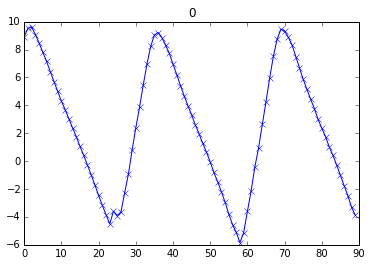

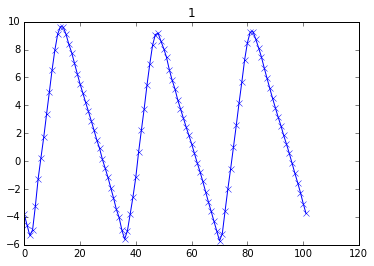

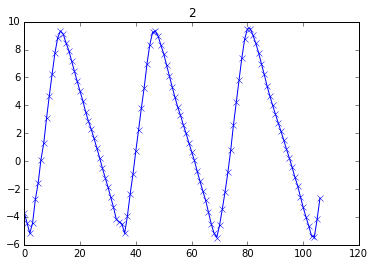

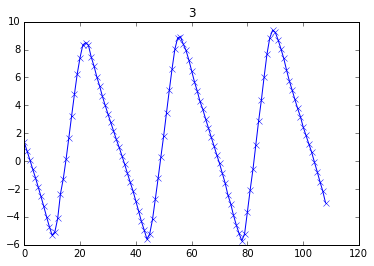

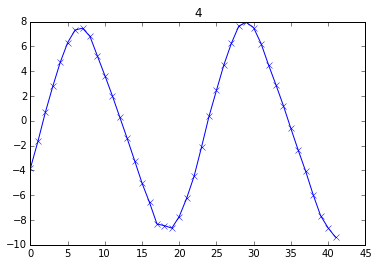

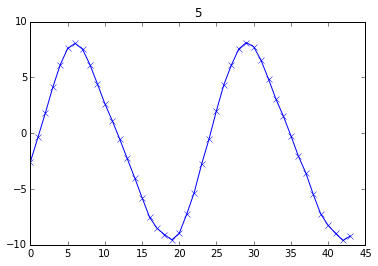

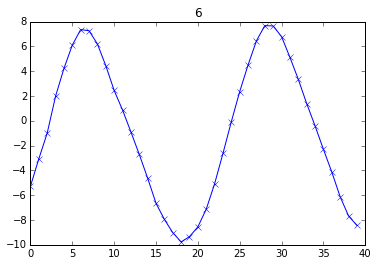

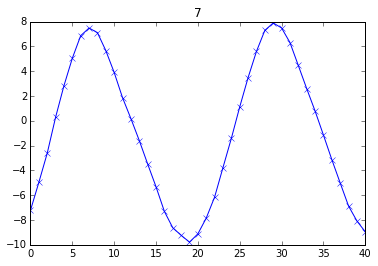

In [7]:
print data_in_train_list[0].shape

for i in range(len(data_in_train_list)):
    plt.figure()
    plt.plot(data_in_train_list[i], 'x-')
    plt.title(i)

In [8]:
y.shape
data_out_train.shape


(575, 59)

In [ ]:
ytest = data['Ytest']
lblstest = data['lblstest']
u = data['Yxyz_list_test']
data_out_test = ytest

data_out_test= data_out_test[:,3:]
data_out_test = (data_out_test-data_out_mean)/data_out_std

data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]][1:] for i in range(lblstest.shape[1])]

# Create controls
#data_in_test_list = [ytest[np.where(lblstest[:,i]==1)[0]][:,2][1:] - ytest[np.where(lblstest[:,i]==1)[0]][:,2][:-1] for i in range(lblstest.shape[1])]
#data_in_test_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_test_list]
data_in_test_list = u

In [ ]:
len(data_in_test_list)

In [ ]:
init_from_saved = False

# Init from saved model
if init_from_saved:
    Q = 100
    
    win_in = 10
    win_out = 10
    
    # create the model
    m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=data_in_train_list, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=True, MLP_dims=[500,200], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                         GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False)])

#f = tables.openFile('./first_10.h5','r')
#ps = f.root.param_array[:]
#m.param_array[:] = ps
#f.close()
#m._trigger_params_changed()

In [ ]:
Q = 100

win_in = 10
win_out = 20

use_controls = True

# create the model
if use_controls:
    m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=data_in_train_list, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=True, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                         GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=False)])
else:
    m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=None, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=True, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                         GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False)])

# initialization
for i in range(m.nLayers):
    m.layers[i].kern.inv_l[:]  = 1./9.#((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))
    m.layers[i].likelihood.variance[:] = 0.01*data_out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)
m.layer_1.likelihood.variance[:] = 0.01
m.layer_0.Y.var()

In [ ]:
# optimization
m.optimize('bfgs',messages=1,max_iters=300)
for i in range(m.nLayers):
    m.layers[i].kern.variance.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=300)
for i in range(m.nLayers):
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

In [ ]:
print m

In [ ]:
m.save('walk_run_2.h5')

In [ ]:
# for i in range(m.nLayers):
#     m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=100000)

In [ ]:
print m

In [ ]:
b = data_in_train.copy()
b[:] = data_in_train.mean()
pd = m.freerun(U=b, m_match=False)

In [ ]:
pd = m.freerun(U=np.ones((300,1))*1.1, m_match=False)

In [ ]:
_=plot(pd[:,0])
_=plot(pd[:,1])
_=plot(pd[:,4])
#_=plot(data_out_train[win_out:100,0],'r')
#_=plot(data_out_train[win_out:100,1],'y')

In [ ]:
!rm imgs/*.png
gen_frames(pd,data_out_mean, data_out_std, data['skel'],'./imgs')

In [ ]:
! avconv -y -r 10 -qscale 2 -i ./imgs/%05d.png pred_walk_run_mid.mp4

In [ ]:
HTML("""
<video width="480" height="480" controls>
  <source src="pred_walk_run.mp4" type="video/mp4">
</video>
""")

In [ ]:
HTML("""
<video width="480" height="480" controls>
  <source src="pred_walk_run.mp4" type="video/mp4">
</video>
""")

In [ ]:
HTML("""
<video width="480" height="480" controls>
  <source src="pred_walk_run_mid.mp4" type="video/mp4">
</video>
""")

In [ ]:
m.layer_1.X.mean.values

In [ ]:
m.layer_1.Us_flat[0].variance

In [ ]:
m.layer_1.kern.lengthscale

In [ ]:
m.layer_0.kern.lengthscale

In [ ]:
m.layer_1.X.mean.std(0)

In [ ]:
plot(data_in_train_list[0])
plot(data_in_train_list[6])

In [ ]:
pd = m.freerun(U=np.vstack([data_in_train_list[0],data_in_train_list[5],data_in_train_list[6],data_in_train_list[7]]),m_match=False)